# Neural Networks: Multilayer perceptrons

The goal of today's session is to get you familiar with neural networks, backpropragation and training. To do that, we will not use any external libraries and we will code from scratch a vanilla multilayer perceptron. 

After this session, we will use standard deep learning libraries, as coding a neural network from scratch is not that easy, as you will see.

In [41]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Activation functions

Activation functions introduce non-linearities in our network. They are a fundamental ingredient in a neural networks, as they allow them to learn highly non-linear mappings between the input and the target domains.

For now we will look only at the classical sigmoid activation function, defined as 

\begin{align}
S(z) = \frac{1}{1 + e^{-z}}.
\end{align}

To train our networks, we will need to compute its derivative:

\begin{align}
\frac{dS}{dz}(z) = \frac{d}{dz} \left( \frac{1}{1 + e^{-z}} \right) = -1 (1 + e^{-z})^{-2} (-e^{-z}) = \frac{e^{-z}}{(1 + e^{-z})^2} = S(z)(1-S(z))
\end{align}

Implement the sigmoid function and its gradient below:

In [42]:
class Sigmoid:
    @staticmethod
    def forward(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def gradient(z):
        return Sigmoid.forward(z) * (1 - Sigmoid.forward(z))

When you are done, you can test your implementation by running the code below:

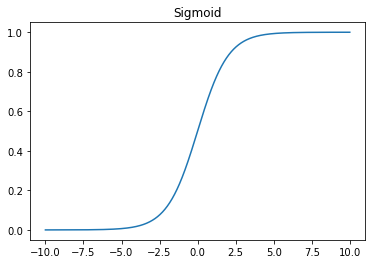

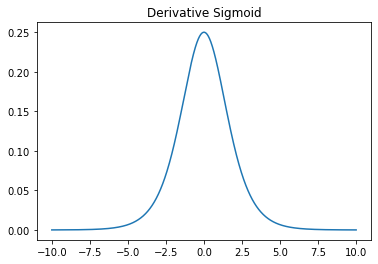

In [43]:
z = np.linspace(-10,10,1000)
S = Sigmoid.forward(z)
dS_dz = Sigmoid.gradient(z)

plt.plot(z, S)
plt.title('Sigmoid')
plt.show()

plt.plot(z, dS_dz)
plt.title('Derivative Sigmoid')
plt.show()


Another very popular activation function, the Rectified Linear Unit (ReLU), is defined as 

\begin{align}
ReLU(z) = \begin{cases}
               0               & z<0\\
               z               & z\geq 0\\ \end{cases}
\end{align}

and its (sub-)derivative reads:

\begin{align}
\frac{d ReLU}{dz}(z) = \begin{cases}
               0               & z<0\\
               1               & z\geq 0\\ \end{cases}
\end{align}

Implement this function and its derivative below:

In [44]:
class ReLU:
    @staticmethod
    def forward(z):
        return np.maximum(0, z)

    @staticmethod
    def gradient(z):
        return np.where(z > 0, 1, 0)

When you are done, you can test your implementation by running the code below:

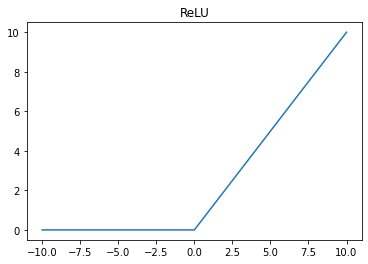

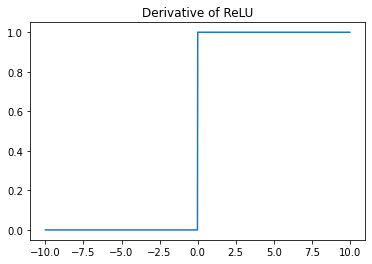

In [45]:
z = np.linspace(-10,10,1000)
T = ReLU.forward(z)
dT_dz = ReLU.gradient(z)

plt.plot(z, T)
plt.title('ReLU')
plt.show()

plt.plot(z, dT_dz)
plt.title('Derivative of ReLU')
plt.show()



# Network

We will now define our first neural network through the Network class.

We implemented for you the constructor of the class, which takes as input a specification of the dimension of each layer $l$ and a list of per-layer activation functions (so that each layer can have a different activation function). 

The initializations for our network are done in the following way:

\begin{align}
W_{(l)}^{(i,j)} &= \frac{\mathcal N(0,1)}{\sqrt{I}} \\ 
W_{(l)}^{(i,0)} &= 0 \, \, \, i=1,\dots,I \\
i&=1,\dots,I \, \, \,  j=1,\dots,J 
\end{align}

where $J,I$ are the number of neurons respectively at the input/output of the $l$-th layer. $W_{(l)}^{(i,j)}$ denotes the **weight** from node $j$ to $i$ in layer $l$ and $W_{(l)}^{(i,0)}$ is the **bias** term for layer $l$, node $i$. Let's change this notation a bit, and call the weights in layer $l$ (without the bias) as $\tilde{\mathbf{W}}_{(l)}$ and the bias as $\mathbf{b}_{(l)}$.

You will have to implement the forward pass of the network, which generates its output $\mathbf{y}$.
Specifically, the input is fed to the network and recursively multiplied with the weights of every layer $l$.
The mathematics of the forward pass are the same for every layer $l$ 
Using the notation we introduced, this can be written as 

\begin{align}
\mathbf{a}_{(l)} &= \tilde{\mathbf{W}}_{(l)}^T \mathbf{z}_{(l-1)} + \mathbf{b}_{(l)}\;. \\
\end{align}

Followed by the nonlinear activation 
\begin{align}
\mathbf{z}_{(l)} &= f_{(l)}(\mathbf{a}_{(l)})
\end{align}
where $f_{(l)}$ denotes the activation function for layer $l$, which is applied independently to every element of the vector $\mathbf{a}_{(l)}$. $\mathbf{z}_{(l)}$ is then the output of layer $l$, and we denote by $\mathbf{z}_{(0)}$ to input ${\bf x}$ (i.e., we can think of the input to the network as the output of layer $0$).

Implement the forward pass in the method $\texttt{feed\_forward}$ below, which takes as input ${\bf x}$ returns ${\bf z}$ and ${\bf a}$, two dictionaries containing the output dimension and activation function for every layer. Keeping track of computed quantities will be useful for training the model. 

Method $\texttt{predict}$, which we have implemented for you, is just a wrapper around $\texttt{feed\_forward}$ yielding the output of our network. 


In [46]:
class Network:
    def __init__(self, dimensions, activations):
        """
        :param dimensions: list of dimensions of the neural net. (input, hidden layer, ... ,hidden layer, output)
        :param activations: list of activation functions. Must contain N-1 activation function, where N = len(dimensions).
        
        Example of one hidden layer with
        - 2 inputs
        - 10 hidden nodes
        - 5 outputs
        layers -->    [0,        1,          2]
        ----------------------------------------
        dimensions =  (2,     10,          5)
        activations = (      Sigmoid,      Sigmoid)
        """
        
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        
        # Weights and biases are initiated by index.
        self.w = {}
        self.b = {}

        # Activations are also initiated by index. 
        self.activations = {}
        for l in range(1, self.n_layers):
            self.w[l] = np.random.randn(dimensions[l - 1], dimensions[l]) / np.sqrt(dimensions[l - 1])
            self.b[l] = np.zeros(dimensions[l])
            self.activations[l] = activations[l-1]


    def feed_forward(self, x):
        """
        Execute a forward feed through the network.
        :param x: (array) Batch of input data vectors.
        :return: (tpl) Node outputs and activations per layer. The numbering of the output is equivalent to the layer numbers.
        """

        # w(x) + b
        a = {}

        # activations: z = f(a)
        z = {0: x}  # First layer has no activations as input, so we consider input itself as the first activation.
        
        for l in range(1, self.n_layers):
            # current layer = l
            a[l] = np.dot(z[l-1], self.w[l]) + self.b[l]
            z[l] = self.activations[l].forward(a[l])

        return z, a
    
    def predict(self, x):
        """
        :param x: (array) Containing parameters
        :return: (array) A 2D array of shape (n_cases, n_classes).
        """
        _, a = self.feed_forward(x)
        return a[self.n_layers - 1]
    

    def back_prop(self, z, a, y_true):
        """
        The input dicts keys represent the layers of the net.
        a = { 0: x,
              1: f(w1(x) + b1)
              2: f(w2(a2) + b2)
              }
        :param a: (dict) w^T@x + b
        :param z: (dict) f(a)
        :param y_true: (array) One hot encoded truth vector.
        :return:
        """

        # Determine partial derivative and delta for the output layer.
        y_pred = z[self.n_layers - 1]
        delta = self.loss_function.gradient(y_true, y_pred) * self.activations[self.n_layers - 1].gradient(y_pred)
        
        dw = np.dot(z[self.n_layers - 2].T, delta)

        update_params = {
            self.n_layers - 1: (dw, delta)
        }

        # Determine partial derivative and delta for the rest of the layers.
        # Each iteration requires the delta from the previous layer, propagating backwards.
        for l in reversed(range(1, self.n_layers - 1)):
            delta = np.dot(delta, self.w[l+1].T) * self.activations[l].gradient(a[l])
            dw = np.dot(z[l - 1].T, delta)
            update_params[l] = (dw, delta)
        
        # finally update weights and biases
        for k, v in update_params.items():
            self.update_w_b(k, v[0], v[1])

    def update_w_b(self, index, dw, delta):
        """
        Update weights and biases.
        :param index: (int) Number of the layer
        :param dw: (array) Partial derivatives
        :param delta: (array) Delta error.
        """

        self.w[index] -= self.learning_rate * dw
        self.b[index] -= self.learning_rate * np.mean(delta, 0)

    def fit(self, x, y_true, loss, epochs, batch_size, learning_rate=1e-3):
        """
        :param x: (array) Containing parameters
        :param y_true: (array) Containing one hot encoded labels.
        :param loss: Loss class (MSE, CrossEntropy etc.)
        :param epochs: (int) Number of epochs.
        :param batch_size: (int)
        :param learning_rate: (flt)
        """
        if not x.shape[0] == y_true.shape[0]:
            raise ValueError("Length of x and y arrays don't match")
        # Initiate the loss object with the final activation function
        self.loss_function = loss
        self.learning_rate = learning_rate

        for i in range(epochs):
            # Shuffle the data
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x_ = x[indices]
            y_ = y_true[indices]

            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_prop(z, a, y_[k:l])

            if (i + 1) % 10 == 0:
                z, _ = self.feed_forward(x)
                print("Loss at epoch {}: {}".format(i + 1, self.loss_function.loss(y_true, z[self.n_layers - 1])))
                
                

You have now created your first neural network, which can produce outputs based on inputs. 
To make sure everything is right, you can run the cell below. It will define a network with 1 input layer, 1 hidden layer and 1 output layer, with 1 node each. This is defined by the `dimensions` parameter, as `(1, 1, 1)`. The activation functions of the hidden layer and output layer are both sigmoid, defined by the `activations` parameter as `(Sigmoid, Sigmoid)`. 

We then generate a random input `x` and pass it through the `feed_forward()` function of the `Network` object. This produces two outputs `z` and `a` which will both be dictionaries, containing the `z` and `a` values the network produces. You will be seeing the following dictionary outputs:

a:
{
	1: "a values of the hidden layer", 
	2: "a values of the output layer"
}

z:
{
	0: "inputs x",
	1: "activations in the hidden layer",
	2: "activations in the output layer"
}

In [47]:
# initialize  network structure
nn = Network((1, 1, 1), (Sigmoid, Sigmoid))
x = np.random.rand(1,1)
z,a = nn.feed_forward(x)
print(z)
print(a)

{0: array([[0.77728535]]), 1: array([[0.18226849]]), 2: array([[0.47208118]])}
{1: array([[-1.50105322]]), 2: array([[-0.11179156]])}


# Loss Function

Loss functions map the predictions of our network into a real number, measuring the error in our predictions.

In this first session we will take the Mean Squared Error (MSE) as our loss function.

Let $\hat{\mathbf{y}}_i \in \mathbb R ^ C$ be the prediction generated by our network for $i$-th data sample, and $\hat{\mathbf{Y}}  \in \mathbb R ^{N \times C} $ be the matrix of N predictions generated for $N$ data points.

Similarly let $\mathbf{Y} \in \mathbb R ^{N \times C}$ be the matrix of true labels $\mathbf{y}_i \in \mathbb R ^ C$.

We then define the MSE of the predictor as

\begin{align}
\mathcal L _{\text{MSE}} =\frac {1}{N} \sum _{i=1}^{N} \frac {1}{C} \sum _{c=1}^{C}\left(\hat{\mathbf{y}}_{i}^{(c)}-{\mathbf{y}_{i}^{(c)}}\right)^{2}.
\end{align}

We can compute its derivative w.r.t. the predictions $\hat{\mathbf{y}}_{i} ^{(c)}$ as

\begin{align}
\frac{\partial \mathcal L _{\text{MSE}} }{\partial \hat{\mathbf{y}}_{i} ^{(c)}} =\frac {2}{NC} \left(\hat{\mathbf{y}}_{i}^{(c)}-{\mathbf{y}_{i} ^{(c)}}\right).
\end{align}

Re-writing this in matrix form gives

\begin{align}
\frac{\partial \mathcal L _{\text{MSE}} }{\partial \hat{\mathbf{Y}}} =\frac {2}{NC} (\hat{\mathbf{Y}}-\mathbf{Y}).
\end{align}

Implement this loss function and its derivatives in matrix form below:

In [48]:
class MSE:
    @staticmethod
    def loss(y_true, y_pred):
        """
        :param y_true: (array) One hot encoded truth vector.
        :param y_pred: (array) Prediction vector
        :return: (flt)
        """
        return np.mean(np.power(y_true - y_pred, 2))

    @staticmethod
    def gradient(y_true, y_pred):
        return (2.0 * (y_pred - y_true))/(y_true.shape[0]*y_true.shape[1])

# Training your network

The loss function $\mathcal L$ gives us information about the prediction error of the model. Our goal is to minimize the loss function by optimizing the weights and biases. 

We know from calculus that if we take the partial derivative of the loss function with respect to a certain weight $W_{(l)}^{(i,j)}$ we get the rate of increase of $\mathcal L$ in that direction. 

The opposite direction of $\frac{\partial \mathcal L }{\partial W_{(l)}^{(i,j)}}$ will then point in the direction that minimizes the loss function.
We can therefore, choosing a step size $\eta$, reduce the loss function by updating our weight as follows
\begin{align}
W_{(l)}^{(i,j)} =W_{(l)}^{(i,j)} - \eta \frac{\partial \mathcal L }{\partial W_{(l)}^{(i,j)}}
\end{align}
This weight optimization is called gradient descent and is done w.r.t. every weight and bias of the network.

To determine the partial derivative of $\mathcal L$ with respect to a certain weight, we can apply the chain rule in differentiation

\begin{align}
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}
\end{align}

In practice this allows us to break down the problem within each layer. We call the whole process backpropagation.


To understand backpropagation, we will take a step back and consider a very simple neural network with one hidden layer (with a single node) taking scalar input $x \in \mathbb R$ and outputting a scalar $y \in \mathbb R$

\begin{align}
a_{(2)} &= \tilde{W}_{(1)} x + b_{(1)} \\
z_{(2)} &= S(a_{(2)}) \\
a_{(3)} &= z_{(2)} \tilde{W}_{(2)} + b^{(2)} \\
y &= S(a_{(3)}) \\
\mathcal L &= (\hat{y}-y)^2
\end{align}

Using the chain rule, compute derivatives of $\mathcal L$ with respect to all weights and biases:
\begin{align}
\frac{\partial \mathcal L}{\partial \hat{y}} &= 2 (\hat{y}-y) \\
\frac{\partial \mathcal L}{\partial a_{(3)}} &= \frac{\partial \mathcal L}{\partial \hat{y}}  \frac{\partial \hat{y}}{\partial a_{(3)}} = 2 (\hat{y}-y) \cdot S(a_{(3)})(1-S(a_{(3)}))  \\
\frac{\partial \mathcal L}{\partial \tilde{W}_{(2)}} &= \frac{\partial \mathcal L}{\partial a_{(3)}} \frac{\partial a_{(3)}}{\partial \tilde{W}_{(2)}} = 2 (\hat{y}-y) \cdot S(a_{(3)})(1-S(a_{(3)})) \cdot z_{(2)} \\
\frac{\partial \mathcal L}{\partial b_{(2)}} &= \frac{\partial \mathcal L}{\partial a_{(3)}} \frac{\partial a_{(3)}}{\partial b_{(2)}} = \cdots \\
\frac{\partial \mathcal L}{\partial z_{(2)}} &= \frac{\partial \mathcal L}{\partial a_{(3)}} \frac{\partial a_{(3)}}{\partial z_{(2)}} = \cdots \\
\frac{\partial \mathcal L}{\partial a_{(2)}} &=  \cdots \\
\frac{\partial \mathcal L}{\partial \tilde{W_{(1)}}} &= \cdots \\
\frac{\partial \mathcal L}{\partial b_{(1)}} &= \cdots 
\end{align}

As things get quite tricky with indices, we have implemented backpropagation for you in method $\texttt{back\_prop}$. Look at it and convince yourself that it generalizes the derivations above to the multi-dimensional case. 

# Fitting your model to MNIST

Now that you have implemented your first neural network, and have understood backpropagation, we will fit our model to the MNIST dataset.

The MNIST database contains a total of 70,000 handwritten digits with 10 different classes, from 0 to 9. 60,000 examples are taken as training dataset and the remaining 10,000 as testing set. The digits have been size-normalized and centered in a fixed-size image. 

First download MNIST from: https://www.python-course.eu/data/mnist/mnist_train.csv
and https://www.python-course.eu/data/mnist/mnist_test.csv
and put these 2 csv files in the same folder as your jupyter notebook file.

To make sure everything went well, we will first load the dataset and visualize some samples from it. It might take a while to load it into memory!

In [49]:
# load the dataset
import numpy as np
import matplotlib.pyplot as plt
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt("mnist_test.csv", 
                       delimiter=",") 

x_train = np.asfarray(train_data[:, 1:])
x_test = np.asfarray(test_data[:, 1:])
y_train = np.asfarray(train_data[:, :1])
y_test = np.asfarray(test_data[:, :1])
# transform labels into one hot representation
lr = np.arange(no_of_different_labels)
y_train = (lr==y_train).astype(np.float)
y_test = (lr==y_test).astype(np.float)

/var/folders/vt/t1qn84c15kvd_fh9hr4kvj840000gn/T/ipykernel_48094/1213266702.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = (lr==y_train).astype(np.float)
/var/folders/vt/t1qn84c15kvd_fh9hr4kvj840000gn/T/ipykernel_48094/1213266702.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = (lr==y_test).astype(np.float)


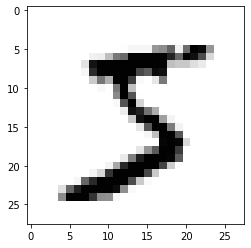

The digit is:  5


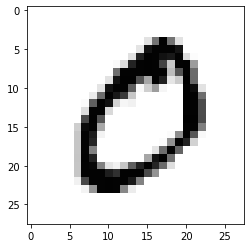

The digit is:  0


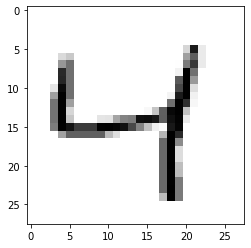

The digit is:  4


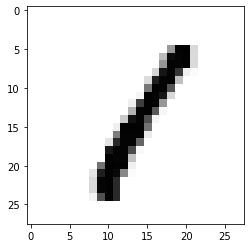

The digit is:  1


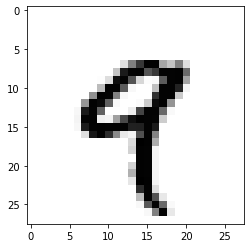

The digit is:  9


In [50]:
# visualize the image and label from the training set
for idx in range(5):
    example_img = np.resize(x_train[idx],(28,28))
    plt.imshow(example_img,cmap="Greys")
    plt.show()
    print ('The digit is: ',y_train[idx].argmax())


You are now ready to fit your model to MNIST. Start by considering a simple one hidden layer MLP with the following specifications:

In [51]:
dimensions =  (28*28, 256,        10)
activations = (  ReLU,  Sigmoid)
epochs = 100
batch_size = 128
learning_rate = 1e-3

Using the Network class implemented above, intialize the network and fit it to the dataset using the MSE loss

In [52]:
# initialize  network structure
nn = Network(dimensions, activations)
# fit network to training data
nn.fit(x_train, y_train, loss=MSE, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

Loss at epoch 10: 0.01900317486222986
Loss at epoch 20: 0.014170986262262998
Loss at epoch 30: 0.011293030411598468
Loss at epoch 40: 0.009555465318812474
Loss at epoch 50: 0.008350644364117086
Loss at epoch 60: 0.007412034747621281
Loss at epoch 70: 0.0066398864760331576
Loss at epoch 80: 0.005972557657459396
Loss at epoch 90: 0.005574121287106754
Loss at epoch 100: 0.005014451263999233


Similarly to previous exercise sessions, let's define a metric to measure the accuracy of our predictions

In [53]:
def accuracy(prediction, ground_truth):
    match = prediction.argmax(axis=1) == ground_truth.argmax(axis=1)
    return float(np.sum(match)) / ground_truth.shape[0]

We can then look at how our network is performing

Loss on TRAIN split: 1507.8111653125184
Accuracy on TRAIN split: 0.9794666666666667
------------------------
Loss on TEST split: 1536.5746126496804
Accuracy on TEST split: 0.9557


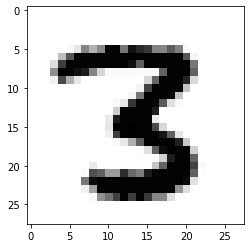

Network prediction:  3
Ground truth annotation:  3


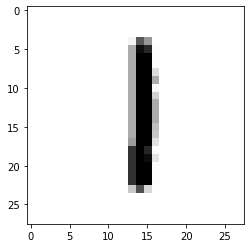

Network prediction:  1
Ground truth annotation:  1


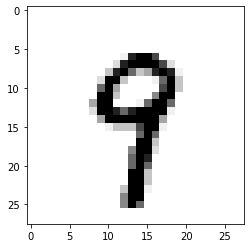

Network prediction:  9
Ground truth annotation:  9


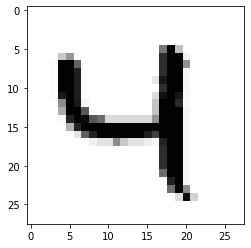

Network prediction:  4
Ground truth annotation:  4


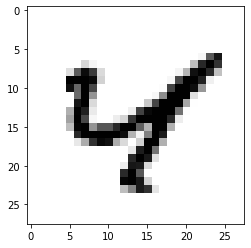

Network prediction:  4
Ground truth annotation:  4


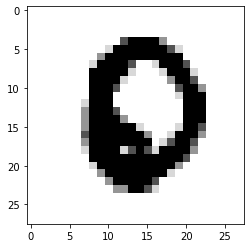

Network prediction:  0
Ground truth annotation:  0


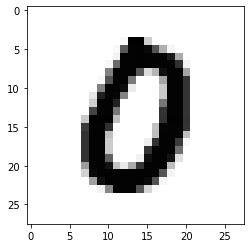

Network prediction:  0
Ground truth annotation:  0


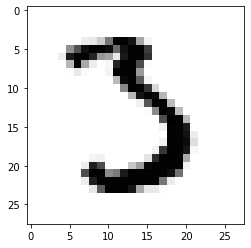

Network prediction:  3
Ground truth annotation:  3


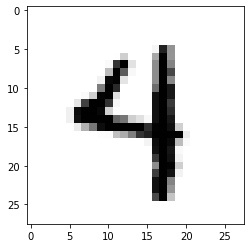

Network prediction:  4
Ground truth annotation:  4


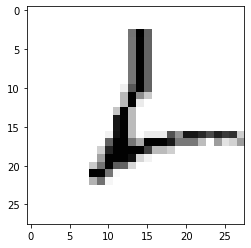

Network prediction:  2
Ground truth annotation:  2


In [54]:
# predict on training split
prediction = nn.predict(x_train)
print("Loss on TRAIN split: {}".format(MSE.loss(prediction, y_train)))
print("Accuracy on TRAIN split: {}".format(accuracy(prediction, y_train)))

print("------------------------")

# predict on testing split
prediction = nn.predict(x_test)
print("Loss on TEST split: {}".format(MSE.loss(prediction, y_test)))
print("Accuracy on TEST split: {}".format(accuracy(prediction, y_test)))

# visualize the image and label from the training set


for _ in range(10):
    idx = np.random.randint(0, x_test.shape[0])
    example_img = np.resize(x_test[idx],(28,28))
    plt.imshow(example_img,cmap="Greys")
    plt.show()
    print ('Network prediction: ',prediction[idx].argmax())
    print ('Ground truth annotation: ',y_test[idx].argmax())


Play around with the architecture, activation functions and hyperparameters to increase the accuracy on the TEST split. You should be able to reach 96% accuracy! (Note that, in principle, one should not tune their model to the test data, but create a validation set.)